# Luther MVP
#### Christopher Giler
#### January 23, 2017
---

To skip directly to Exploratory Data Analysis, click <a href='#EDA'><strong>HERE</strong></a>

#### Import Required Libraries

In [4]:
import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 100

#### Loading Data

In [5]:
## Load the data
import pickle
with open('boxoffice_opening_weekend_screens.pkl', 'rb') as picklefile:
    num_screens = pickle.load(picklefile)
with open('df_total_stars.pkl', 'rb') as picklefile:
    df_total_stars = pickle.load(picklefile)

#### Preprocessing Data

In [6]:
num_screens = num_screens[num_screens['Country'] == 'United States']
num_screens = num_screens[num_screens['Num_Theaters'] > 0]
num_screens.drop_duplicates(inplace=True)
num_screens = num_screens.groupby('tconst').sum()
num_screens.reset_index(inplace=True)
num_screens.head()

,tconst,Num_Theaters,Price
0,tt0365907,2712,12758780
1,tt0369610,4274,208806270
2,tt0376479,50,149038
3,tt0420293,2,37514
4,tt0435651,3003,12305016


In [7]:
df_total_stars_screens = df_total_stars.merge(num_screens, how='inner', on='tconst')

In [9]:
keep_columns = ['tconst', 'nconst', 'birthYear', 'primaryProfession', 'Name',
                'mpaa_rating', 'metacritic_score', 'averageRating',
                'release', 'title', 'genres', 'Num_Theaters', 'Price']

df = df_total_stars_screens[keep_columns+['Start Date', 'End Date', 'Star Ranking']].copy()
df.head()

,tconst,nconst,birthYear,primaryProfession,Name,mpaa_rating,metacritic_score,averageRating,release,title,genres,Num_Theaters,Price,Start Date,End Date,Star Ranking
0,tt0365907,nm1003922,1971,producer,Brian Oliver,R,57,6.5,2014-09-19,A Walk Among the Tombstones,Crime,2712,12758780,2013-01-20 00:00:00,2013-02-17 00:00:00,33380
1,tt0365907,nm1003922,1971,producer,Brian Oliver,R,57,6.5,2014-09-19,A Walk Among the Tombstones,Crime,2712,12758780,2013-02-17 00:00:00,2013-03-17 00:00:00,40639
2,tt0365907,nm1003922,1971,producer,Brian Oliver,R,57,6.5,2014-09-19,A Walk Among the Tombstones,Crime,2712,12758780,2013-03-17 00:00:00,2013-04-14 00:00:00,40571
3,tt0365907,nm1003922,1971,producer,Brian Oliver,R,57,6.5,2014-09-19,A Walk Among the Tombstones,Crime,2712,12758780,2013-04-14 00:00:00,2013-05-12 00:00:00,43860
4,tt0365907,nm1003922,1971,producer,Brian Oliver,R,57,6.5,2014-09-19,A Walk Among the Tombstones,Crime,2712,12758780,2013-05-12 00:00:00,2013-06-09 00:00:00,36932


#### Creating New Features From Available Data

- **Release Year** (from release date)
- **Release Season** (from release date)
- **Weighted Score** (average of IMDB rating and metacritic rating)
- **Opening Weekend Gross Per Theater**

In [10]:
## Engineer new features

# Release Year of Film
df['release_year'] = df['release'].dt.year
keep_columns.append('release_year')

# Release Season of Film
Y = 2000
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)
df['release_season'] = df['release'].apply(get_season)
keep_columns.append('release_season')

# Convert start and end dates to date format
df['Start Date'] = df['Start Date'].dt.date
df['End Date'] = df['End Date'].dt.date

# Weighted Score (Average of IMDB score and Metacritic score)
df['weighted_score'] = (df['metacritic_score']*0.1 + df['averageRating'])/2
keep_columns.append('weighted_score')

# Opening Weekend Gross Ticket Sales per Theater
df['opening_per_theater'] = df['Price'] / df['Num_Theaters']
keep_columns.append('opening_per_theater')

# Find dates of 1 month, 6 month, and 1 year in advance compared to release date
def find_prev_datetime(date, num_months):
    return (date - timedelta(num_months*30))

df['release_1_month_prev'] = df['release'].apply(lambda x: find_prev_datetime(x, 1))
keep_columns.append('release_1_month_prev')
df['release_6_month_prev'] = df['release'].apply(lambda x: find_prev_datetime(x, 6))
keep_columns.append('release_6_month_prev')
df['release_12_month_prev'] = df['release'].apply(lambda x: find_prev_datetime(x, 12))
keep_columns.append('release_12_month_prev')

In [11]:
# df.head()

#### Engineer more advanced features (based on star ranking)

- **average_star_rank_[X]_month_[Y]** - max star rank up to [X] months before release for [Y] top-rated actor(s)
    - X -> [0, 1, 6, 12]
    - Y -> [1, 2, 3, 4, 5]

In [13]:
num_actors = range(1,6)
num_months_advance = [12, 6, 1, 0]
col_names = []
star_power = []
for nma in num_months_advance:
    if nma > 0:
        df_use = df[(df['release_' + str(nma) + '_month_prev'].dt.date - df['Start Date']) > timedelta(0)]
    else:
        df_use = df[(df['release'].dt.date - df['Start Date']) > timedelta(0)]
        
    for na in num_actors:
        col_name = 'average_star_rank_' + str(nma) + '_month_' + str(na)
        col_names.append(col_name)
        star_power.append(df_use.groupby(['title', 'Name']).agg({'Star Ranking': np.min})['Star Ranking'].groupby(level=0, group_keys=False).nsmallest(na).groupby(['title']).mean())

In [14]:
df_star_power = pd.DataFrame([], columns=col_names)
for i, cur_df in zip(col_names, star_power):
    df_star_power[i] = cur_df
df_star_power.head()

,average_star_rank_12_month_1,average_star_rank_12_month_2,average_star_rank_12_month_3,average_star_rank_12_month_4,average_star_rank_12_month_5,average_star_rank_6_month_1,average_star_rank_6_month_2,average_star_rank_6_month_3,average_star_rank_6_month_4,average_star_rank_6_month_5,average_star_rank_1_month_1,average_star_rank_1_month_2,average_star_rank_1_month_3,average_star_rank_1_month_4,average_star_rank_1_month_5,average_star_rank_0_month_1,average_star_rank_0_month_2,average_star_rank_0_month_3,average_star_rank_0_month_4,average_star_rank_0_month_5
title,,,,,,,,,,,,,,,,,,,,
'71,822,874.5,2256.000000,6685.50,10401.6,262,542.0,2034.333333,5181.75,7904.2,175,401.0,703.000000,2291.50,5467.8,175,401.0,703.000000,2105.75,4615.2
10 Cloverfield Lane,5,6.0,79.333333,142.50,353.8,5,6.0,79.333333,142.50,353.8,5,6.0,79.333333,142.50,288.8,5,6.0,58.666667,127.00,198.6
13 Hours,37,44.5,63.333333,93.75,552.4,37,44.5,63.333333,79.50,173.2,37,44.5,63.333333,79.50,173.2,37,44.5,54.000000,65.75,145.6
13 Minutes,1656,2731.5,3485.666667,6337.25,9231.2,1656,2731.5,3485.666667,6337.25,9231.2,1656,2731.5,3485.666667,6337.25,9231.2,1656,2731.5,3485.666667,6337.25,9231.2
13 Sins,2054,3251.5,4357.666667,5548.00,8122.2,299,398.0,1924.666667,3723.25,6662.4,299,398.0,1269.333333,2415.25,4469.0,299,398.0,1269.333333,2415.25,3856.0


In [16]:
df_titles = df[keep_columns].drop(['nconst', 'Name', 'birthYear'], axis=1)
df_titles.drop_duplicates(subset=['tconst'], inplace=True)
df_titles.set_index('title', drop=True, inplace=True)

In [17]:
# df_titles.head()

In [18]:
print('Length of df_star_power: %d' % len(df_star_power))
print('Length of df_titles: %d' % len(df_titles))

Length of df_star_power: 999
Length of df_titles: 1004


In [19]:
df_all = df_titles.join(df_star_power)
df_all.head()

,tconst,primaryProfession,mpaa_rating,metacritic_score,averageRating,release,genres,Num_Theaters,Price,release_year,release_season,weighted_score,opening_per_theater,release_1_month_prev,release_6_month_prev,release_12_month_prev,average_star_rank_12_month_1,average_star_rank_12_month_2,average_star_rank_12_month_3,average_star_rank_12_month_4,average_star_rank_12_month_5,average_star_rank_6_month_1,average_star_rank_6_month_2,average_star_rank_6_month_3,average_star_rank_6_month_4,average_star_rank_6_month_5,average_star_rank_1_month_1,average_star_rank_1_month_2,average_star_rank_1_month_3,average_star_rank_1_month_4,average_star_rank_1_month_5,average_star_rank_0_month_1,average_star_rank_0_month_2,average_star_rank_0_month_3,average_star_rank_0_month_4,average_star_rank_0_month_5
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Walk Among the Tombstones,tt0365907,producer,R,57,6.5,2014-09-19,Crime,2712,12758780,2014,summer,6.10,4704.564897,2014-08-20,2014-03-23,2013-09-24,46.0,56.0,171.000000,313.00,1124.8,45.0,55.5,170.666667,312.75,1124.6,45.0,55.5,170.666667,300.75,644.0,34.0,50.0,167.0,260.00,513.4
Pride and Prejudice and Zombies,tt1374989,producer,PG-13,45,5.8,2016-02-05,Action,2931,5324240,2016,winter,5.15,1816.526783,2016-01-06,2015-08-09,2015-02-10,3.0,34.5,50.666667,68.00,1050.0,1.0,33.5,50.000000,67.50,1049.6,1.0,33.5,50.000000,67.50,379.6,1.0,33.5,50.0,67.50,379.6
Clown,tt1780798,producer,R,42,5.7,2016-06-17,Horror,100,26920,2016,spring,4.95,269.200000,2016-05-18,2015-12-20,2015-06-23,196.0,208.0,234.333333,366.75,2369.4,76.0,80.5,127.000000,286.25,2305.0,76.0,80.5,127.000000,286.25,2305.0,76.0,80.5,127.0,286.25,1919.6
American Made,tt3532216,producer,R,65,7.2,2017-09-29,Action,3024,16776390,2017,autumn,6.85,5547.748016,2017-08-30,2017-04-02,2016-10-04,3.0,6.0,22.000000,39.75,154.4,3.0,6.0,22.000000,39.75,154.4,3.0,6.0,10.000000,21.00,112.8,3.0,4.5,6.0,18.00,110.4
The Quiet Ones,tt2235779,producer,PG-13,41,5.1,2014-04-25,Horror,2027,3880053,2014,spring,4.60,1914.185002,2014-03-26,2013-10-27,2013-04-30,98.0,384.5,507.000000,3300.75,6330.2,69.0,236.0,408.000000,1785.75,4426.8,2.0,83.0,306.000000,520.00,1873.6,2.0,83.0,306.0,496.25,1734.0


<a id='EDA'></a>
## Exploratory Data Analysis
---

In [ ]:
import seaborn as sns
sns.set_style('white_grid')

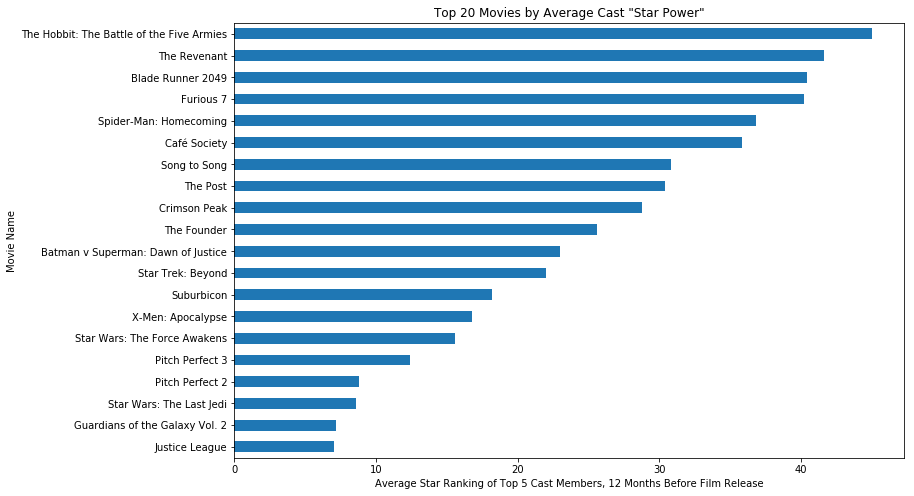

In [37]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
df_all.reset_index().sort_values('average_star_rank_12_month_5', ascending=True).head(20).plot('title', 'average_star_rank_12_month_5', kind='barh', ax=ax)
ax.set_ylabel('Movie Name')
ax.set_xlabel('Average Star Ranking of Top 5 Cast Members, 12 Months Before Film Release')
ax.set_title('Top 20 Movies by Average Cast "Star Power"')
ax.legend_.remove()

The data here makes sense, as films with a greater number of well-known actors and actresses have a lower average star ranking. In this case, lower star ranking indicates a higher "star-power" metric.

To continue the exploration, I'm looking at the distribution of opening weekend box office sales, both in total and average per theater.

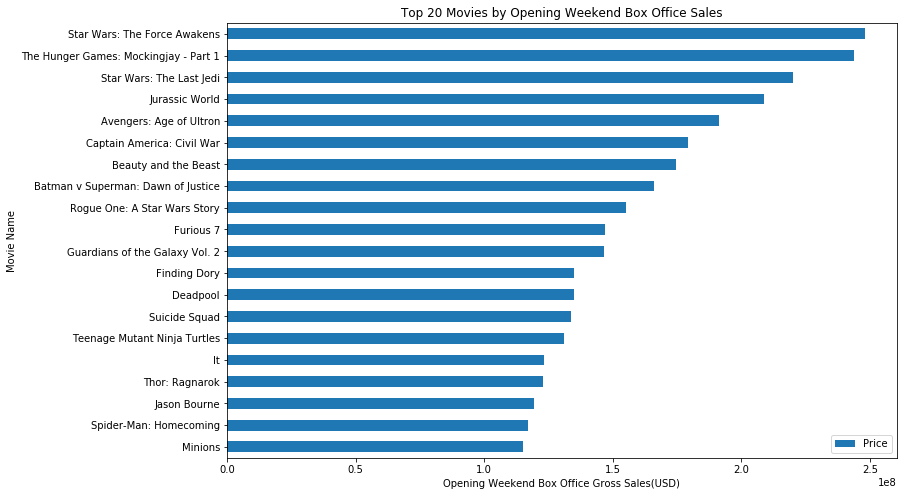

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
df_all.reset_index().sort_values('Price', ascending=True).tail(20).plot('title', 'Price', kind='barh', ax=ax)
ax.set_ylabel('Movie Name')
ax.set_xlabel('Opening Weekend Box Office Gross Sales(USD)')
ax.set_title('Top 20 Movies by Opening Weekend Box Office Sales')

The chart indicates that "Star Wars: The Force Awakens" has the highest opening weekend U.S. gross of all movies released since 2014. This film is known to have broken a number of box office records, including:
- Fastest film to gross $1 Billion
- Biggest worldwide opening weekend gross

This data appears to make sense.

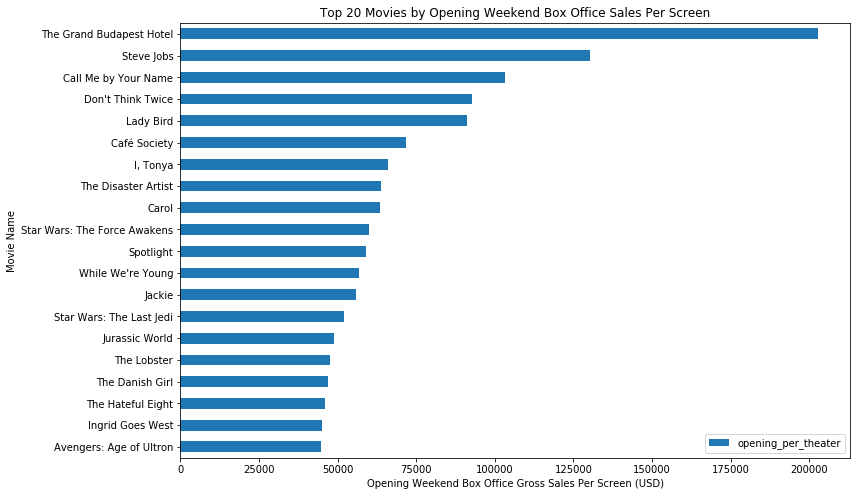

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
df_all.reset_index().sort_values('opening_per_theater', ascending=True).tail(20).plot('title', 'opening_per_theater', kind='barh', ax=ax)
ax.set_ylabel('Movie Name')
ax.set_xlabel('Opening Weekend Box Office Gross Sales Per Screen (USD)')
ax.set_title('Top 20 Movies by Opening Weekend Box Office Sales Per Screen')

This metric tells a bit of a different story. While the overall box office data gives an idea of hard sales, looking at the gross sales per theater gives a better idea of consumer response. In North America, "The Grand Budapest Hotel" opened in only 4 cinemas in its first weekend, and grossed a total of \$811,166 (or over \$200k per theater)

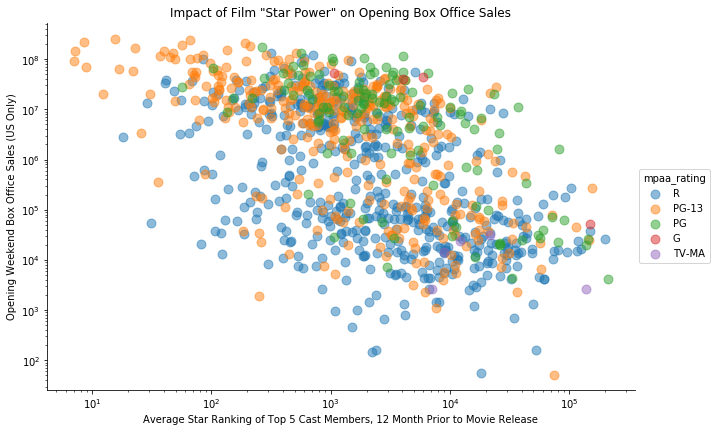

In [29]:
grid = sns.lmplot('average_star_rank_12_month_5', 'Price', data=df_all, hue='mpaa_rating', fit_reg=False, scatter_kws={'alpha': 0.5, 's': 80}, size=6, aspect=1.5)
grid.ax.loglog()
grid.ax.set_ylabel('Opening Weekend Box Office Sales (US Only)')
grid.ax.set_xlabel('Average Star Ranking of Top 5 Cast Members, 12 Month Prior to Movie Release')
grid.ax.set_title('Impact of Film "Star Power" on Opening Box Office Sales')

Finally, we look at the average star ranking and it's supposed impact on opening weekend box office sales. 

There's a clear separation between two groups, which represent limited releases vs. big-studio, nation-wide releases. 

There's also a clear separation of ratings - films released by big studios tend to have a less restrictive rating than those released on a smaller scale. This contributes to total sales because PG and PG-13 movies are much more accessible to a wider audience.

For larger budget movies, there's also some negative correlation between average star ranking and opening weekend box office gross. It appears that films with a less widely-known cast (shown by a higher star ranking), have lower sales on opening weekend. However, other features will need to be considered to build a model to predict opening weekend box office sales from this data.